# predicting sequential data
2025-05-16
Reference https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/ 


## step 1 import libraries 

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Step 2: create synthetic dataset

In [ ]:
def generate_data(seq_length, num_samples):
    X = []
    y = []
    for i in range(num_samples):
        x = np.linspace(i * 2 * np.pi, (i + 1) * 2 * np.pi, seq_length + 1)
        sine_wave = np.sin(x)
        X.append(sine_wave[:-1])  
        y.append(sine_wave[1:])   
    return np.array(X), np.array(y)

seq_length = 50
num_samples = 1000
X, y = generate_data(seq_length, num_samples) # sample 里有1000个样本，每个样本50个点

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(X.shape, y.shape)

torch.Size([1000, 50]) torch.Size([1000, 50])


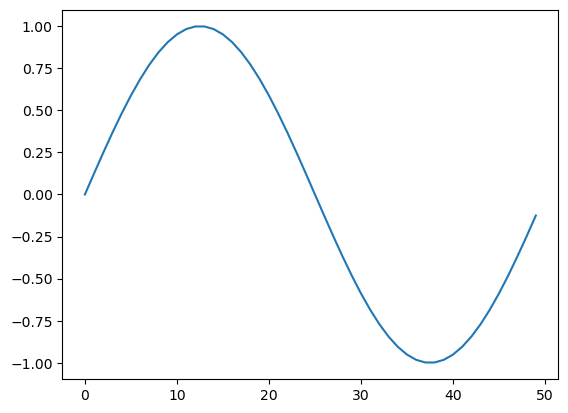

In [13]:
plt.figure(1)
plt.plot(X[0].numpy(), label='Input')

## Step 3: Define the RNN model

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__() # 调用父类nn.Module的构造函数
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) 
    #! batch_first=True时，输入 x的形状是 (batch_size, seq_length, input_size) - RNN 输出out形状（m, Tx, nx）
    #! batch_first=False时，输入 x的形状是 (seq_length, batch_size, input_size) -RNN 输出out形状（Tx, m, nx）
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 20
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

## Step 4: Train the model

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X.unsqueeze(2))
    loss = criterion(outputs, y.unsqueeze(2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.0061
Epoch [20/1000], Loss: 0.0026
Epoch [30/1000], Loss: 0.0013
Epoch [40/1000], Loss: 0.0006
Epoch [50/1000], Loss: 0.0004
Epoch [60/1000], Loss: 0.0002
Epoch [70/1000], Loss: 0.0002
Epoch [80/1000], Loss: 0.0002
Epoch [90/1000], Loss: 0.0001
Epoch [100/1000], Loss: 0.0001
Epoch [110/1000], Loss: 0.0001
Epoch [120/1000], Loss: 0.0001
Epoch [130/1000], Loss: 0.0001
Epoch [140/1000], Loss: 0.0001
Epoch [150/1000], Loss: 0.0002
Epoch [160/1000], Loss: 0.0001
Epoch [170/1000], Loss: 0.0001
Epoch [180/1000], Loss: 0.0001
Epoch [190/1000], Loss: 0.0001
Epoch [200/1000], Loss: 0.0001
Epoch [210/1000], Loss: 0.0001
Epoch [220/1000], Loss: 0.0001
Epoch [230/1000], Loss: 0.0001
Epoch [240/1000], Loss: 0.0001
Epoch [250/1000], Loss: 0.0001
Epoch [260/1000], Loss: 0.0003
Epoch [270/1000], Loss: 0.0002
Epoch [280/1000], Loss: 0.0001
Epoch [290/1000], Loss: 0.0001
Epoch [300/1000], Loss: 0.0001
Epoch [310/1000], Loss: 0.0001
Epoch [320/1000], Loss: 0.0001
Epoch [330/1000],

## Step 5: Visualize the results

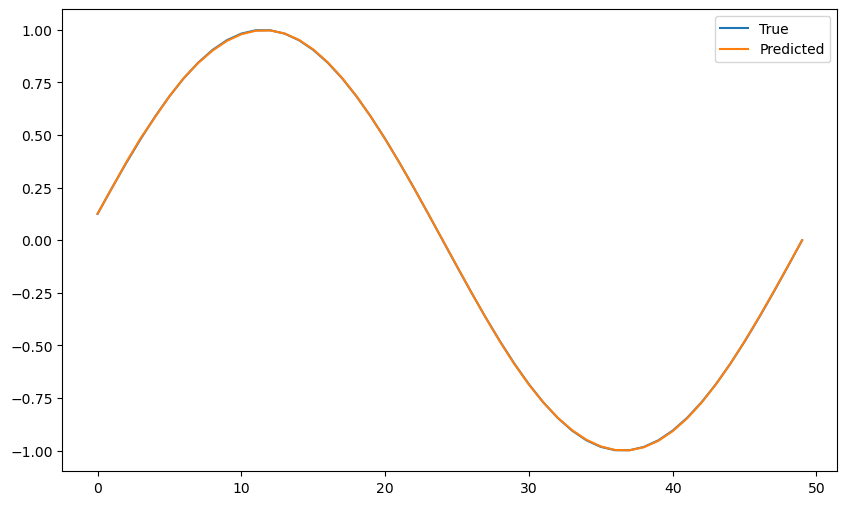

In [7]:
model.eval()
with torch.no_grad():
    predictions = model(X.unsqueeze(2)).squeeze(2).numpy()

plt.figure(figsize=(10, 6))
plt.plot(y[0].numpy(), label='True')
plt.plot(predictions[0], label='Predicted')
plt.legend()
plt.show()

# Classifying Movie Reviews Using RNN

## Step 1: import libraries

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


## Step 2: Load and preprocess the dataset

In [9]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, delimiter='\t', header=None, names=['label', 'text'])

def preprocess_text(text):
    return text.lower().split()

df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'label']]

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

vocab = set([word for phrase in df['text'] for word in phrase])
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

def encode_phrase(phrase):
    return [word_to_idx[word] for word in phrase]

train_data['text'] = train_data['text'].apply(encode_phrase)
test_data['text'] = test_data['text'].apply(encode_phrase)

max_length = max(df['text'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

## Step 3: Create Dataset and Data Loader

In [10]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

这段代码的核心作用是构建一个高效的数据管道，将预处理好的数据适配给 PyTorch 模型进行训练和评估。

SentimentDataset 负责定义如何从原始数据源（这里是 DataFrame）中逐个提取样本，并将这些样本转换为 PyTorch 张量。它是一个数据源的接口。
DataLoader 则在 SentimentDataset 的基础上，提供了更高级的功能，如自动将样本组合成批次 (batching)、随机打乱数据顺序 (shuffling)（主要用于训练），以及可能的并行数据加载（以提高效率，虽然在这个代码片段中未显式配置多线程）。

## step4: Define the RNN model

In [11]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2 
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

## Step 5: Train the model  

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 0.4029
Epoch [2/10], Loss: 0.4001
Epoch [3/10], Loss: 0.3955
Epoch [4/10], Loss: 0.3985
Epoch [5/10], Loss: 0.3959
Epoch [6/10], Loss: 0.3951
Epoch [7/10], Loss: 0.3994
Epoch [8/10], Loss: 0.3955
Epoch [9/10], Loss: 0.3958
Epoch [10/10], Loss: 0.3965


## Step 6: Evaluate the model

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

## Step 7: Visualize Training Loss

In [ ]:
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    losses.append(epoch_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()